# Mapping data to the Human Lung Cell Atlas for joint analysis and cell type label transfer

In this tutorial we will show how to map single-cell data to a reference. Such mapping yields a joint embedding of the reference and the mapped ("query") data, which can be used for downstream analysis including clustering and trajectory analysis. Moreover, once the data is mapped, it is possible to perform label transfer from the reference to the query, thus providing a first annotation of all cells in the query data with minimial effort. We will use the [Human Lung Cell Atlas](https://github.com/LungCellAtlas/HLCA) as an example reference. We will furthermore use the scANVI model previously generated to integrate the datasets in the HLCA as our base reference model, on which we will perform scArches surgery to enable mapping and batch correction of the query dataset. Finally, we use a KNN classifier from scArches to perform cell type label transfer from the reference to the query.

As the HLCA was annotated at five different levels (coarse to fine annotations), we will also display five different levels of cell annotation and their uncertainties for our mapping.

This notebook was compiled by Lisa Sikkema.

**Note**: the label transfer section of this notebook shows a bug in some environments with older scvi-tools and scanpy. We haven't figured out yet what exactly causes this. If you observe random label assignment during label transfer, make sure to update your packages and re-run. The bug has not been observed in environments with `scanpy>=1.9.3`, `scarches>=0.5.8` and `scvi-tools>=0.20.3`.

## Setup

### Import libraries and set figure parameters and paths

In [1]:
import os

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import sys
import scanpy as sc
import numpy as np
import pandas as pd
import scarches as sca
import anndata as ad
from scipy import sparse
import gdown
import gzip
import shutil
import urllib.request

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:[rank: 0] Global seed set to 0
/home/icb/lisa.sikkema/miniconda3/envs/HLCA_mapping_env_new_upgrade_scanpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set scanpy figure parameters:

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

Set paths:

In [4]:
ref_model_dir_prefix = "."  # directory in which to store the reference model directory
surgery_model_dir_prefix = (
    "."  # directory in which to store the surgery model directory
)
path_reference_emb = (
    "./HLCA_emb_and_metadata.h5ad"  # path to reference embedding to be created
)
path_query_data = "./HLCA_query.h5ad"  # input test query data
# don't change the following paths:
ref_model_dir = os.path.join(
    ref_model_dir_prefix, "HLCA_reference_model"
)  # don't change this
surgery_model_dir = os.path.join(
    surgery_model_dir_prefix, "surgery_model"
)  # don't change this

### Download reference data and reference model:

We will start with downloading the needed model and data. First, let's download the reference model, on which we will perform surgery. The HLCA reference model can be found on Zenodo, and we'll download it below:

In [6]:
url = "https://zenodo.org/record/7599104/files/HLCA_reference_model.zip"
output = "HLCA_reference_model.zip"
gdown.download(url, output, quiet=False)
shutil.unpack_archive("HLCA_reference_model.zip", extract_dir=ref_model_dir_prefix)
os.remove(output)

We will furthermore download the reference itself. As scArches allows the mapping of query data onto an existing reference *embedding*, we will only need to download the embedding of the HLCA reference. That saves a lot of time and memory compared to downloading the full count matrix. It might take a while to download this embedding, it's 2.3Gb in size.

In [7]:
url = "https://zenodo.org/record/7599104/files/HLCA_full_v1.1_emb.h5ad"
output = path_reference_emb
gdown.download(url, output, quiet=False)

Let's load our downloaded reference embedding:

In [8]:
adata_ref = sc.read_h5ad(path_reference_emb)

This embedding includes both the HLCA core (healthy reference, integrated with scANVI) and the HLCA extension (core + lung disease datasets mapped with scArches). We will subset to the HLCA core here, as this is what the reference model was trained on.

In [9]:
# subset
adata_ref = adata_ref = adata_ref[adata_ref.obs.core_or_extension == "core", :].copy()
# remove all obs variables that have no entries anymore (i.e. obs columns that were only relevant for the HLCA extension)
cols_to_drop = [
    col for col in adata_ref.obs.columns if adata_ref.obs[col].isnull().all()
]
adata_ref.obs.drop(columns=cols_to_drop, inplace=True)

### Load query data and match feature naming with reference model:

Finally, we need to have query data which we want to map to the reference. For this tutorial, we will use an example [dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171668) from the [Delorey et al. publication](  https://www.nature.com/articles/s41586-021-03570-8.) as query dataset to map to the HLCA reference, but you can use your own data for this as well. For our example, we only use one sample  (the fresh single-cell sample) from the Delorey dataset. We already prepared an .h5ad file for that sample in this repository, so no need to download this file, we can just load it:

In [10]:
adata_query_unprep = sc.read_h5ad(path_query_data)

Now we prepare our query data, so that it includes the right genes (this depends on the genes used for the reference model, missing genes are padded with zeros) and has those genes in the right order. Preparing your query data ensures data corectness and smooth running of the scArches reference mapping.

First, make sure that your counts matrix is sparse for memory efficiency:

In [11]:
adata_query_unprep.X = sparse.csr_matrix(adata_query_unprep.X)

Remove obsm and varm matrices to prevent errors downstream:

In [12]:
del adata_query_unprep.obsm
del adata_query_unprep.varm

Note that the data should have raw counts and not normalized counts in adata.X. Let's do a quick check to see if we have integer data:

In [13]:
adata_query_unprep.X[:10, :30].toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         6., 46.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

Looks like we do. Now let's check if our reference model uses gene names or gene ids as input features. We will need to match our query data with the reference model.

In [14]:
ref_model_features = pd.read_csv(
    os.path.join(ref_model_dir, "var_names.csv"), header=None
)

In [15]:
ref_model_features.head(5)

0
0  ENSG00000000938
1  ENSG00000000971
2  ENSG00000002587
3  ENSG00000002933
4  ENSG00000003436

As you can see, the HLCA reference model requires ensemble IDs. Therefore, if your data includes ensembl IDs, we can proceed and use the standard scArches function to subset and pad our query AnnData. Make sure your `adata_query_unprep.var.index` contains the gene ids. If you instead only have gene names and no IDs for your query data, we will have to prepare your data manually (see below).

The test data already has ensembl ids as index:

In [16]:
adata_query_unprep.var.head(5)

gene_ids    feature_types  genome   gene_names
ENSG00000243485  ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG
ENSG00000237613  ENSG00000237613  Gene Expression  GRCh38      FAM138A
ENSG00000186092  ENSG00000186092  Gene Expression  GRCh38        OR4F5
ENSG00000238009  ENSG00000238009  Gene Expression  GRCh38   AL627309.1
ENSG00000239945  ENSG00000239945  Gene Expression  GRCh38   AL627309.3

#### If your query feature naming (ensembl IDs or gene symbols) does not match the reference model feature naming:

If your query feature naming does not match your reference model feature naming, you will need to add the right feature names. For the HLCA reference, the mapping of the 2000 input gene IDs to their gene names is stored on the HLCA Zenodo page, so you can add gene ids using that mapping. Alternatively, you can map your gene IDs to gene names (or the reverse) using [BioMart mapping tables](https://www.ensembl.org/biomart/martview/cc971635f3c3dd8346aa9c6e685edce7). In most cases your raw data includes both gene IDs and names, in which case mapping is not necessary. 

Let's download the HLCA-specific gene mapping:

In [17]:
# path_gene_mapping_df = os.path.join(ref_model_dir, "HLCA_reference_model_gene_order_ids_and_symbols.csv")

In [18]:
# # Download gene information from HLCA github:
# url = "https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv" 
# gdown.download(url, path_gene_mapping_df, quiet=False)

Load the mapping table:

In [19]:
# gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)

Store your gene names in an adata.var.column if they are currently the index:

In [20]:
# adata_query_unprep.var.head(2)

In [21]:
## if gene names are in .var.index:
# adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index

and then specify the gene name column name:

In [22]:
# gene_name_column_name = "gene_names"

Map gene names to gene ids for all of the 2000 reference model genes that we can find in our data:

Check number of detected genes:

In [23]:
# n_overlap = (
#     adata_query_unprep.var[gene_name_column_name]
#     .isin(gene_id_to_gene_name_df.gene_symbol)
#     .sum()
# )
# n_genes_model = gene_id_to_gene_name_df.shape[0]
# print(
#     f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
# )

Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above. Store the resulting ids both in the .var.index (for scArches) and in a .var[gene_ids] (for merging duplicate genes).

In [24]:
# adata_query_unprep = adata_query_unprep[
#     :,
#     adata_query_unprep.var[gene_name_column_name].isin(
#         gene_id_to_gene_name_df.gene_symbol
#     ),
# ].copy()  # subset your data to genes used in the reference model
# adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
#     dict(zip(gene_id_to_gene_name_df.gene_symbol, gene_id_to_gene_name_df.index))
# )  # add gene ids for the gene names, and store in .var.index
# # remove index name to prevent bugs later on
# adata_query_unprep.var.index.name = None
# adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index

Check that we now have ensembl IDs in .var.index:

In [25]:
# adata_query_unprep.var.head(3)

Sum any columns with identical gene IDs that have resulted from the mapping. Here we define a short function to do that easily.

In [26]:
# def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
#     adata.strings_to_categoricals()
#     assert pd.api.types.is_categorical_dtype(adata.obs[col])

#     cat = adata.obs[col].values
#     indicator = sparse.coo_matrix(
#         (np.broadcast_to(True, adata.n_obs), (cat.codes, np.arange(adata.n_obs))),
#         shape=(len(cat.categories), adata.n_obs),
#     )

#     return ad.AnnData(
#         indicator @ adata.X, var=adata.var, obs=pd.DataFrame(index=cat.categories)
#     )

shape before merging:

In [27]:
# adata_query_unprep.shape

Now merge. Note that all var columns will be dropped after merging (as we don't specify how to merge). As the merging is done based on .obs indices in the function above, we transpose our anndata object and re-transpose it after merging.

In [28]:
# adata_query_unprep = sum_by(adata_query_unprep.transpose(), col="gene_ids").transpose()

Check the final shape of your query data:

In [29]:
# adata_query_unprep.shape

add back gene ids:

In [30]:
# gene_id_to_gene_name_df

In [31]:
# adata_query_unprep.var = adata_query_unprep.var.join(gene_id_to_gene_name_df).rename(columns={"gene_symbol":"gene_names"})

### Prepare query data for scArches:

Now that we have the right feature naming in our query anndata, we  can finalize preparation of our query AnnData object for mapping. This includes padding of missing genes (setting them to 0).

In [32]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata=adata_query_unprep, reference_model=ref_model_dir, inplace=False
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   
INFO     Found 99.65% reference vars in query data.                                                                


Your query adata will now have the same number of genes as the number of model input features:

In [33]:
adata_query

AnnData object with n_obs × n_vars = 1786 × 2000
    obs: 'dataset'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'

You'll see that scarches printed the percentage of model input features ("reference vars") that it could find in the query data. If this number is too low, it will affect the quality of your mapping. For example, we noticed low-quality mapping in a dataset for which we had only 1300 genes out of 2000 (65%).

### Load reference model and set relevant query variables:

Let's load our reference model, on which we will perform surgery:

In [34]:
surgery_model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_model_dir,
    freeze_dropout=True,
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   


The reference model will have a number of variables that you will need to set as well. Let's check the variables for our reference model:

In [35]:
surgery_model.registry_["setup_args"]

{'labels_key': 'scanvi_label',
 'unlabeled_category': 'unlabeled',
 'layer': None,
 'batch_key': 'dataset',
 'size_factor_key': None,
 'categorical_covariate_keys': None,
 'continuous_covariate_keys': None}

There are three setup arguments that were used for building the reference model, and that should be used for preparing scArches surgery as well:<br>
    1. `batch_key`: this key is used to specify from which batch your query dataset comes. The HLCA reference model was set up to retain variation between individuals, and so rather than treating each sample or individual as a separate batch, each dataset was considered one batch. We therefore recommend using the same logic for an HLCA query, and set an entire dataset to a single batch. If your data has further splits that could result in specific batch effects, split your data into separate batches accordingly (e.g. if part of your data was generated with 10X 3', and the rest with 10X 5').<br>
    2. `labels_key`: as the HLCA has a scANVI reference model, it used cell type labels as input for the training. These cell type labels were stored in a column named 'scanvi_label'. We recommend not using cell type labels for surgery, and so advise to set this column to 'unlabeled' (see below).<br>
    3. `unlabeled_category`: this variable specifies how cells without label were named for this specific model. As you can see, they were in this case set to the string 'unlabeled'.

Our test data will be considered only a single batch, and so we set our batch key to a single value:

In [36]:
adata_query.obs["dataset"] = "Delorey_batch_1"

We will furthermore set the cell type key to the unlabeled_category for all our cells, and recommend doing the same for any dataset mapped to the HLCA:

In [37]:
adata_query.obs["scanvi_label"] = "unlabeled"

Re-load the surgery model, now with the variables for adata_query set:

In [38]:
surgery_model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_model_dir,
    freeze_dropout=True,
)

INFO     File ./HLCA_reference_model/model.pt already downloaded                                                   


### Set relevant training/surgery length and kwargs

TO DO: add explanations/tuning options with these parameters

In [39]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

## Perform surgery on reference model by training on the query dataset

We will now update the reference model by performing scArches surgery. During surgery, only those parts of the model are trained that affect how your query is embedded; the reference embedding cannot change. In that way, the embedding of your query data is partly based on pre-learned patterns in the reference, and partly based on the query data itself.

In [40]:
surgery_model.train(max_epochs=surgery_epochs, **early_stopping_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:15<00:00,  6.91it/s, loss=510, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:15<00:00,  6.61it/s, loss=510, v_num=1]


Let's save the model:

In [41]:
surgery_model.save(surgery_model_dir, overwrite=True)

And load if starting from here:

In [42]:
surgery_model = sca.models.SCANVI.load(
    surgery_model_dir, adata_query
)  # if already trained

INFO     File ./surgery_model/model.pt already downloaded                                                          


## Obtain query latent embedding

Now that we have the updated model, we can calculate the low-dimensional representation or "embedding" of our query data. Importantly, this embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.! The latent embedding will be stored in a new anndata under .X with the following command:

In [43]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))

Copy over .obs metadata from our query data:

In [44]:
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index, :]

## Combine reference and query embedding into one joint embedding

Now that we have our query embedding, we can combine it with the pre-existing reference embedding that we downloaded at the top of this notebook. Once we have that joint embedding, we can do all kinds of analyses on the combined reference and query, including clustering, visualization, and label transfer (see below).

Before joining the reference and the query, let's specify for the cells from each whether they came from the reference or the query: 

In [45]:
adata_query_latent.obs["ref_or_query"] = "query"
adata_ref.obs["ref_or_query"] = "ref"

We will now combine the two embeddings to enable joint clustering etc. If you expect non-unique barcodes (.obs index), set `index_unique` to e.g. "_" (this will add a suffix to your barcodes to ensure we can keep apart reference and query barcodes) and `batch_key` to the obs column that you want to use as barcode suffix (e.g. "ref_or_query").

In [46]:
combined_emb = sc.concat(
    (adata_ref, adata_query_latent), index_unique=None, join="outer"
)  # index_unique="_", batch_key="ref_or_query")

Save the combined embedding if wanted. As the data concatenation might have resulted in some mixed dtype obs columns, we will convert those to strings here to prevent writing errors below.

In [47]:
for cat in combined_emb.obs.columns:
    if isinstance(combined_emb.obs[cat].values, pd.Categorical):
        pass
    elif pd.api.types.is_float_dtype(combined_emb.obs[cat]):
        pass
    else:
        print(
            f"Setting obs column {cat} (not categorical neither float) to strings to prevent writing error."
        )
        combined_emb.obs[cat] = combined_emb.obs[cat].astype(str)

Setting obs column is_primary_data (not categorical neither float) to strings to prevent writing error.
Setting obs column dataset (not categorical neither float) to strings to prevent writing error.
Setting obs column scanvi_label (not categorical neither float) to strings to prevent writing error.
Setting obs column ref_or_query (not categorical neither float) to strings to prevent writing error.


In [48]:
combined_emb.write_h5ad("combined_embedding.h5ad")

Read if starting from here.

In [49]:
combined_emb = sc.read_h5ad("combined_embedding.h5ad")

Note that it is possible to not only combine the embeddings of the refence and query, but to add the actual gene counts to this embedding. This enables querying of gene expression across the query and reference. The full HLCA, including normalized counts is publicly available on cellxgene. For now, we will just work with the embedding, since that is all we need to perform joint visualization and label transfer.

## Label transfer

Next, we use a knn classifier to transfer the lables from the reference to the query. As the HLCA includes 5 levels of annotations (from coarse to fine), we will do the label transfer for every level of annotation.
Note that some cell types don't have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we will "propagate" to the higher levels, i.e. you will see "3_Mast cells" in level 4 and 5 annotations. (Most cell types don't have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [50]:
path_celltypes = os.path.join(ref_model_dir, "HLCA_celltypes_ordered.csv")

In [51]:
url = "https://github.com/LungCellAtlas/HLCA_reproducibility/raw/main/supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv" # "https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv"
gdown.download(url, path_celltypes, quiet=False)

Import the set of finest cell type labels, and their matching lower-level annotations (cell types are also ordered in a biologically sensible order in this table, you can use this order for downstream plotting etc. if wanted):

In [52]:
cts_ordered = pd.read_csv(path_celltypes, index_col=0).rename(
    columns={f"Level_{lev}": f"labtransf_ann_level_{lev}" for lev in range(1, 6)}
)

In [53]:
cts_ordered.head(5)

labtransf_ann_level_1 labtransf_ann_level_2   
Basal resting                    Epithelial     Airway epithelium  \
Suprabasal                       Epithelial     Airway epithelium   
Hillock-like                     Epithelial     Airway epithelium   
Deuterosomal                     Epithelial     Airway epithelium   
Multiciliated (nasal)            Epithelial     Airway epithelium   

                       labtransf_ann_level_3 labtransf_ann_level_4   
Basal resting                          Basal         Basal resting  \
Suprabasal                             Basal            Suprabasal   
Hillock-like                           Basal          Hillock-like   
Deuterosomal           Multiciliated lineage          Deuterosomal   
Multiciliated (nasal)  Multiciliated lineage         Multiciliated   

                       labtransf_ann_level_5  ordering   colors  
Basal resting                4_Basal resting         3  #FFFF00  
Suprabasal                      4_Suprabasal         4  #1CE6FF  
Hillock-like                  4_Hillock-like        11  #FF34FF  
Deuterosomal                  4_Deuterosomal        13  #FF4A46  
Multiciliated (nasal)  Multiciliated (nasal)        15  #008941

Let's add annotations for all five levels including forward-propagated labels (see above) to our adata_ref. They will be stored in adata_ref.obs under `labtransf_ann_level_[1-5]`.

In [54]:
adata_ref.obs = adata_ref.obs.join(cts_ordered, on="ann_finest_level")

In [55]:
adata_ref

AnnData object with n_obs × n_vars = 584944 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tis

check subset of copy results:

In [56]:
adata_ref.obs.loc[:, ["ann_finest_level", "labtransf_ann_level_4"]].head(5)

ann_finest_level   
CGATGTAAGTTACGGG_SC10                  Alveolar macrophages  \
ATTCTACCAAGGTTCT_HD68                 EC aerocyte capillary   
P1_2_TGCTGCTAGCTCCTCT                  Alveolar macrophages   
CTGATAGTCTTAGAGC_F01367                         EC arterial   
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14       Club (non-nasal)   

                                      labtransf_ann_level_4  
CGATGTAAGTTACGGG_SC10                  Alveolar macrophages  
ATTCTACCAAGGTTCT_HD68                 EC aerocyte capillary  
P1_2_TGCTGCTAGCTCCTCT                  Alveolar macrophages  
CTGATAGTCTTAGAGC_F01367                       3_EC arterial  
D344_Brus_Dis1_CATTCGCGTGCCTGCA-1-14                   Club

Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

Let's prepare our label transfer:

In [57]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",  # location of our joint embedding
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

Now let's peform label transfer for the 5 levels of labels in the reference ("ann_level_1" to "ann_level_5").

In [58]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X",  # location of our embedding, query_adata.X in this case
    label_keys="labtransf_ann_level_",  # (start of) obs column name(s) for which to transfer labels
    knn_model=knn_transformer,
    ref_adata_obs=adata_ref.obs,
)

finished!


With the commands above, we labeled every cell from the query (`labels` dataframe). Moreover, for each query cell we get an uncertainty score that tells you how confidently the label was assigned to the cell (`uncert` dataframe). This uncertainty score is based on how consistent the reference labels were among the nearest neighbors of the query cell. High label transfer uncertainty can indicate a number of things:<br>
1. The cell lies in between two cellular phenotypes, e.g. in the case of a continuous transition of one cell type into another.<br>
2. The cell is of a cell type or subtype not present in the reference. For example, the HLCA does not include erythrocytes. Erythrocytes in a query dataset will therefore likely be labeled with high uncertainty. Similarly, disease samples might include disease-affected cell types that look different from the cells in a healthy reference. These also likely have high label transfer uncertainty.
3. The mapping did not successfully remove batch-effects in the query data from the embedding. Query cells do not mix with the reference in the joint embedding, complicating confident label transfer.
To distinguish low-uncertainty from high-uncertainty transferred labels, we will set our high-uncertainty labels to "unknown" instead of giving them a cell type label. Cells with high uncertainty should be looked into in downstream analysis.

We set the uncertainty threshold to 0.2, limiting the false positive rate to <0.5 (as per [Sikkema et al., bioRxiv 2022](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1)). If you are dealing with data that you expect to look very different from your reference (e.g. mouse data or cell line data), you could consider setting this threshold higher.

In [59]:
uncertainty_threshold = 0.2

Let's clean up the column names and add the transferred labels and matching uncertainties to our combined embedding (including both the query and the reference).

In [60]:
labels.rename(
    columns={
        f"labtransf_ann_level_{lev}": f"ann_level_{lev}_transferred_label_unfiltered"
        for lev in range(1, 6)
    },
    inplace=True,
)
uncert.rename(
    columns={
        f"labtransf_ann_level_{lev}": f"ann_level_{lev}_transfer_uncert"
        for lev in range(1, 6)
    },
    inplace=True,
)

In [61]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

Now let's generate a filtered label column for each label, setting labels transferred with uncertainty >0.2 to "Unknown":

In [62]:
for lev in range(1, 6):
    combined_emb.obs[f"ann_level_{lev}_transferred_label"] = combined_emb.obs[
        f"ann_level_{lev}_transferred_label_unfiltered"
    ].mask(
        combined_emb.obs[f"ann_level_{lev}_transfer_uncert"] > uncertainty_threshold,
        "Unknown",
    )

Let's take a look at the percentage of cells set to "unknown" after our filtering:

In [63]:
print(
    f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:"
)
for level in range(1, 6):
    print(
        f"Level {level}: {np.round(sum(combined_emb.obs[f'ann_level_{level}_transferred_label'] =='Unknown')/adata_query.n_obs*100,2)}%"
    )

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.56%
Level 2: 1.12%
Level 3: 10.64%
Level 4: 51.12%
Level 5: 51.23%


**Important note!** In some environments with older versions of scanpy/scvi-tools/scarches, there is a bug in the above code that we have not been able to properly pinpoint and fix. If you observe percentages of (close to) 100% of unknown above, you likely have the same bug and should update your packages. The transfered labels will then also be shuffled/random. (See also note at the top of this notebook).

## Visualization of the joint reference and query embedding

We will use a UMAP plot of our data to visually inspect the results of the mapping and label transfer. Calculating this will take a while on the HLCA (>.5M cells) + query.

In [64]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_mapping_env_new_upgrade_scanpy/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/lisa.sikkema/miniconda3/envs/HLCA_mapping_env_new_upgrade_scanpy/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numb

Let's first take a look at where our query cells are located in the umap. If they are completely separate from the reference, this could be a sign that something went wrong in the mapping. In our case, the query cells are largely mixing with or close to the reference cells in the UMAP.

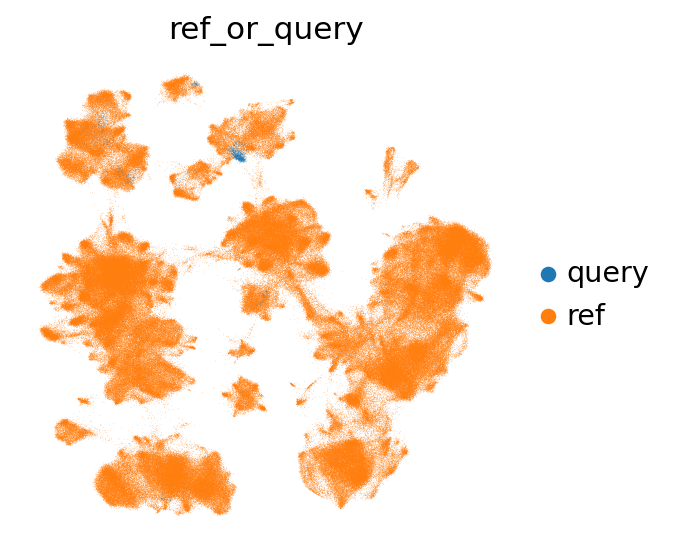

In [65]:
sc.pl.umap(combined_emb, color="ref_or_query", frameon=False, wspace=0.6)

Now let's take a look at the label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go. Note that as we only used very few cells in the query here, they are more difficult to see in the joint embedding.

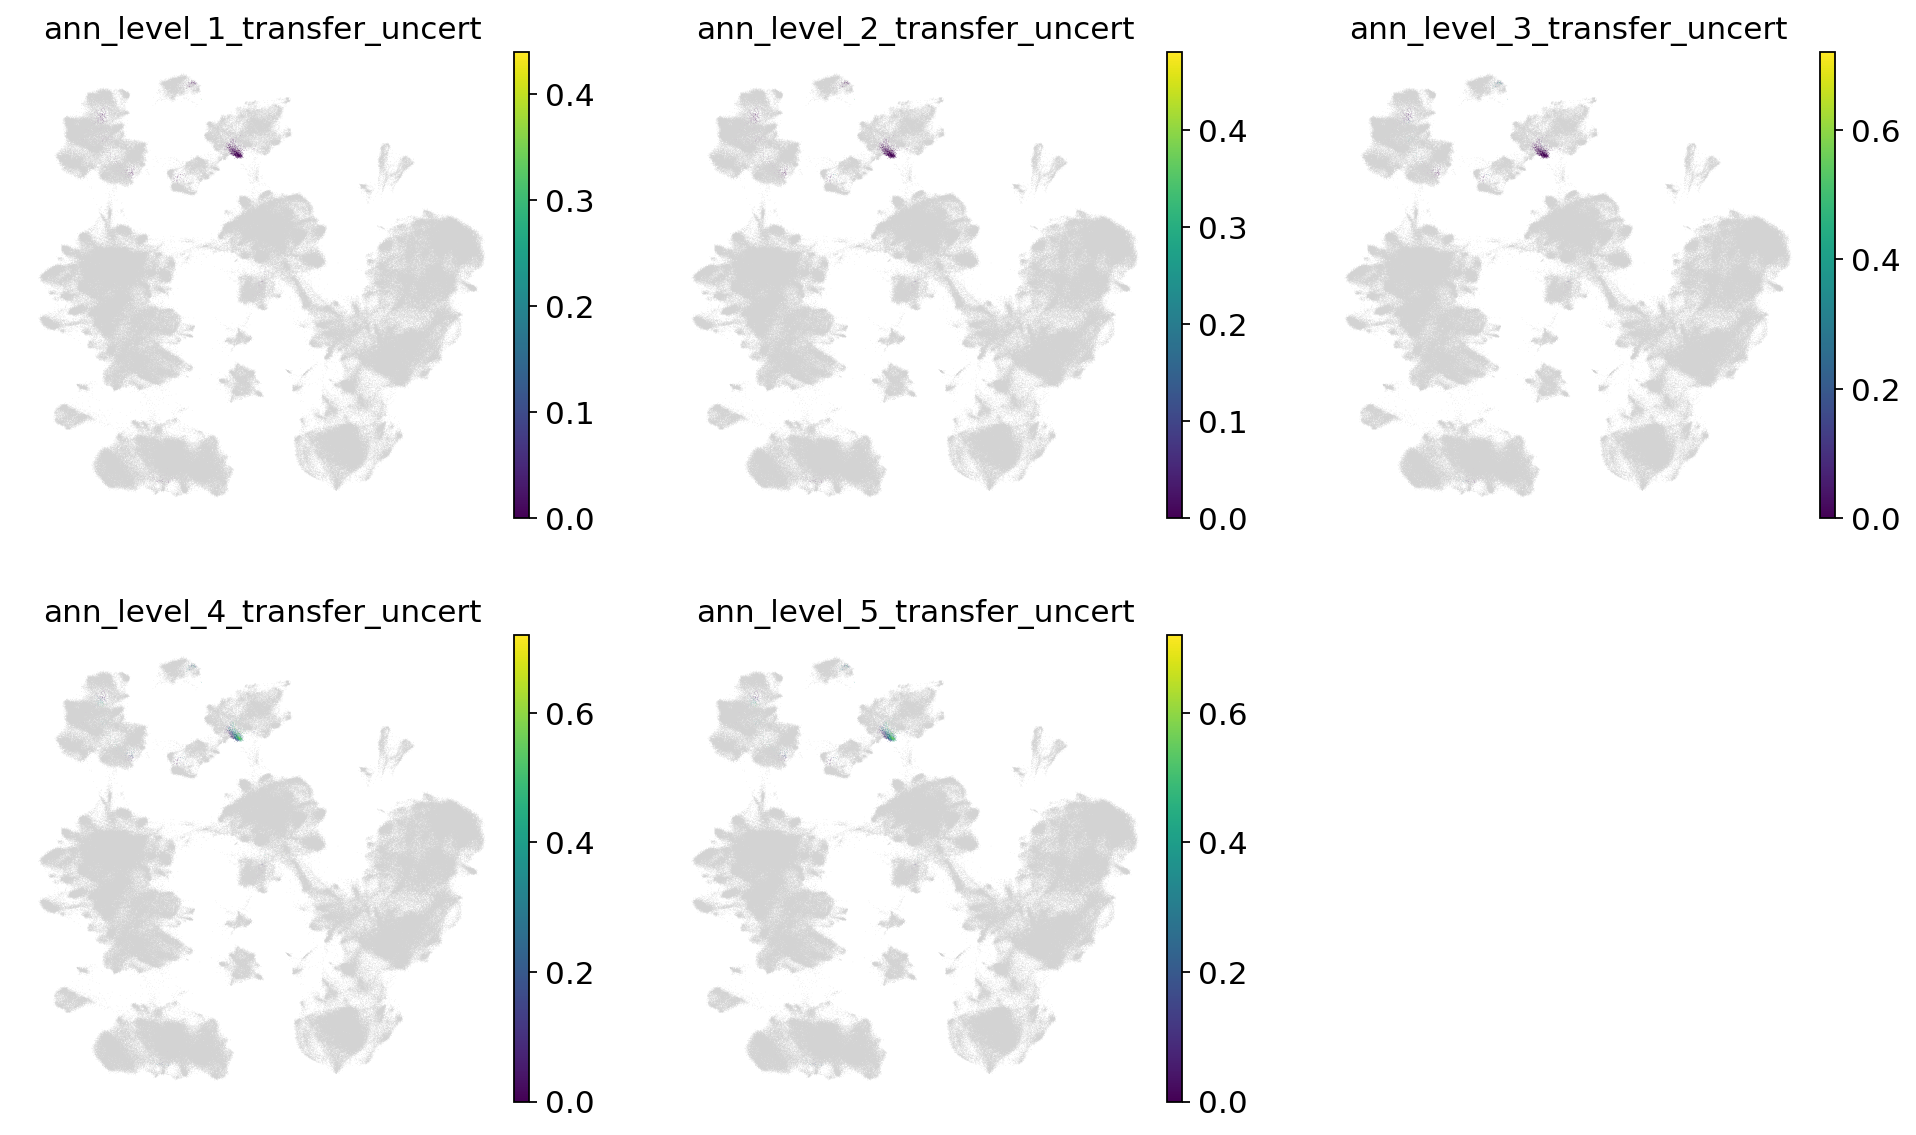

In [66]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transfer_uncert" for lev in range(1, 6)],
    ncols=3,
    frameon=False,
)

Now let's take a look at the transferred labels, at every level. Note that the color for "Unknown" switches per plot, and that all cells from the reference are set to NA.

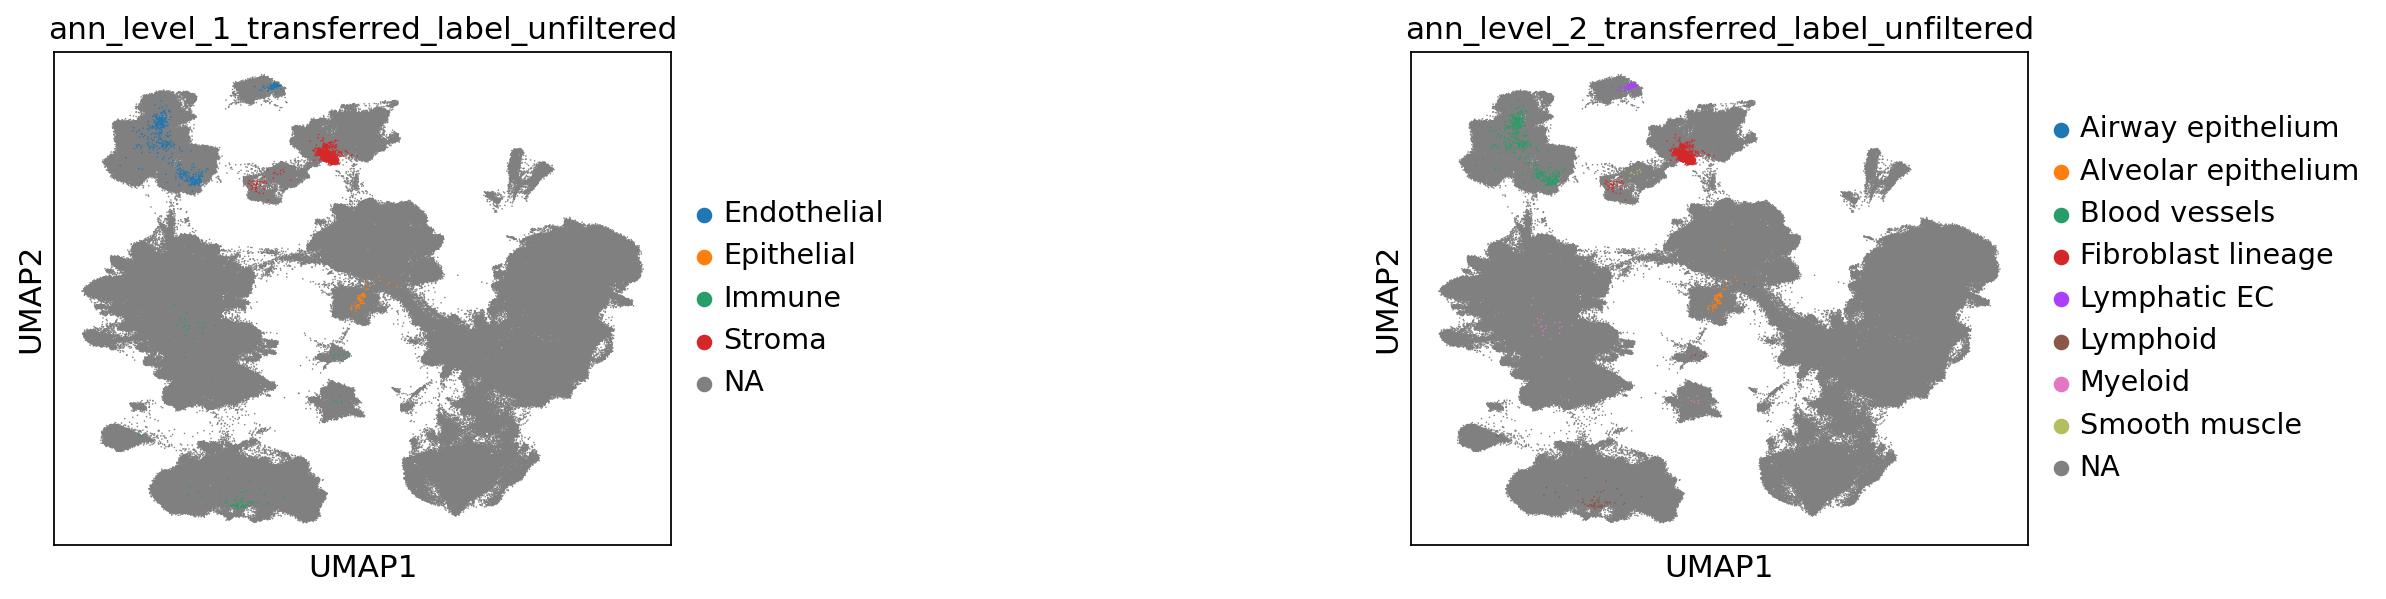

In [67]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transferred_label_unfiltered" for lev in range(1, 3)],
    na_color="grey",
    ncols=2,
    size=2,
    wspace=1,
)

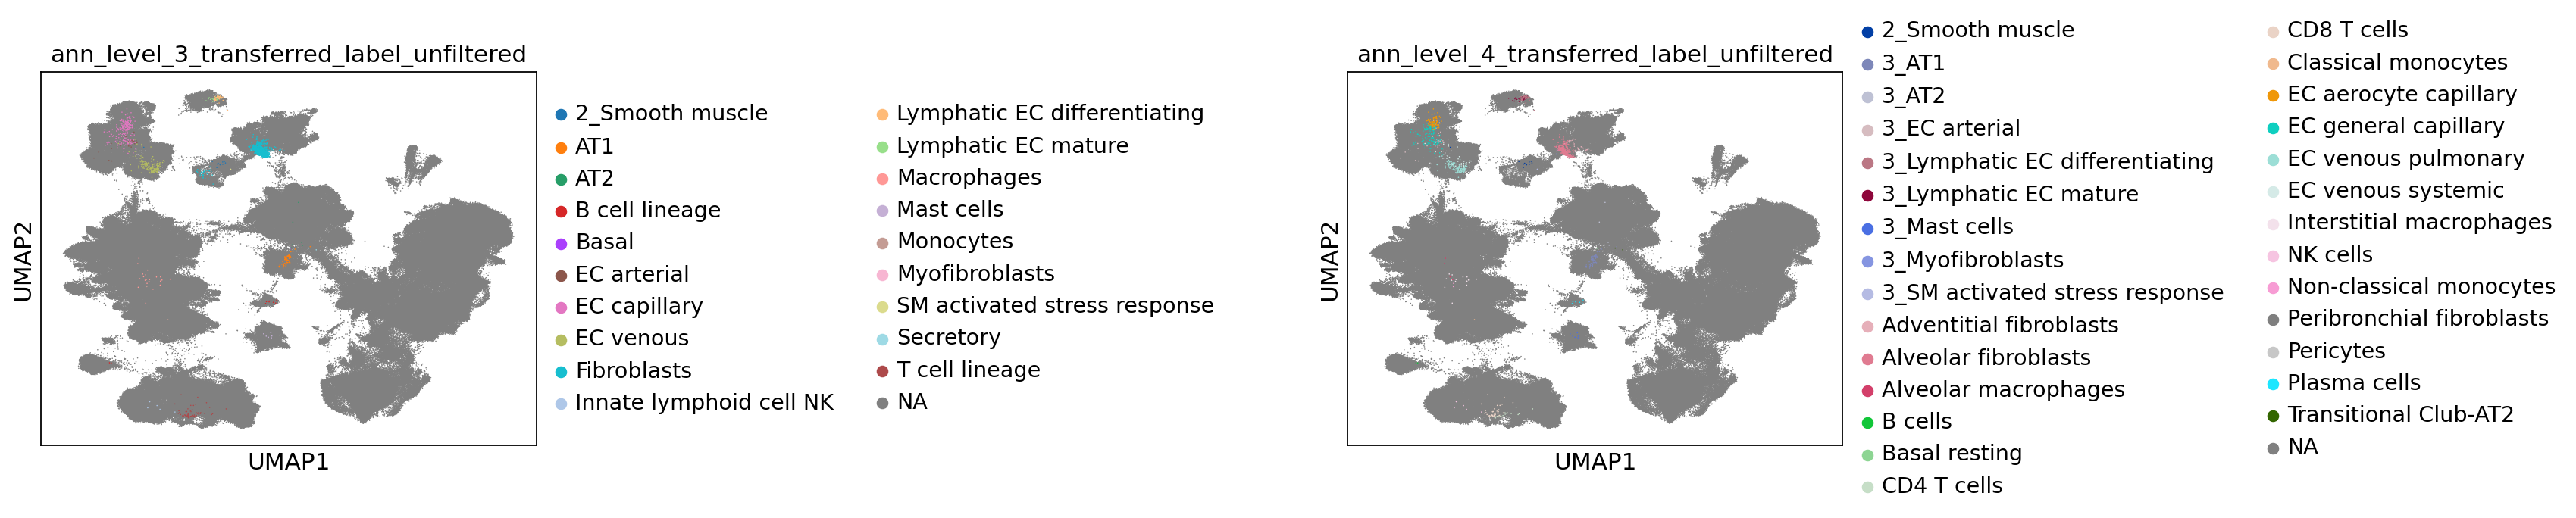

In [68]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_{lev}_transferred_label_unfiltered" for lev in range(3, 5)],
    na_color="grey",
    ncols=2,
    size=2,
    wspace=1.4,
)

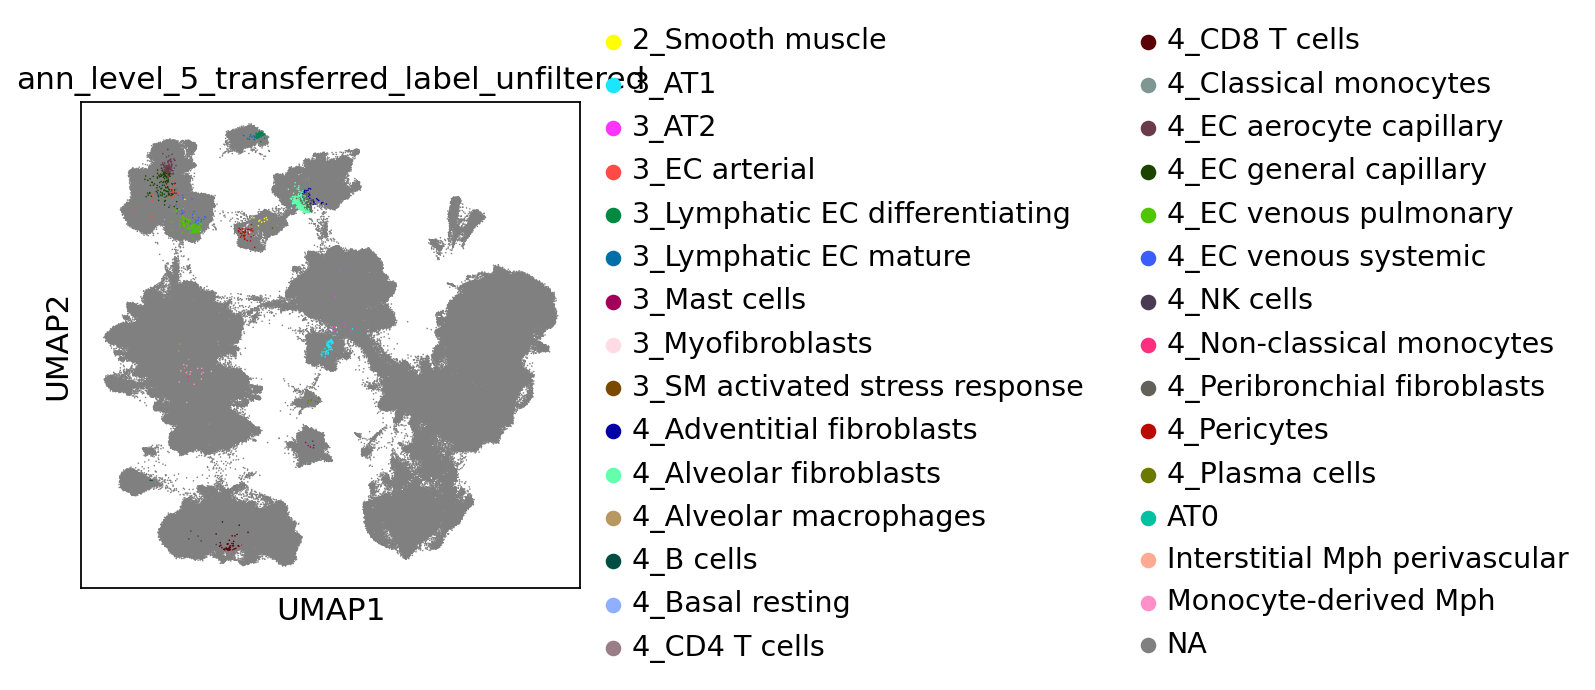

In [69]:
sc.pl.umap(
    combined_emb,
    color=[f"ann_level_5_transferred_label_unfiltered"],
    na_color="grey",
    size=2,
)

For your reference, these are the annotations of the reference atlas:

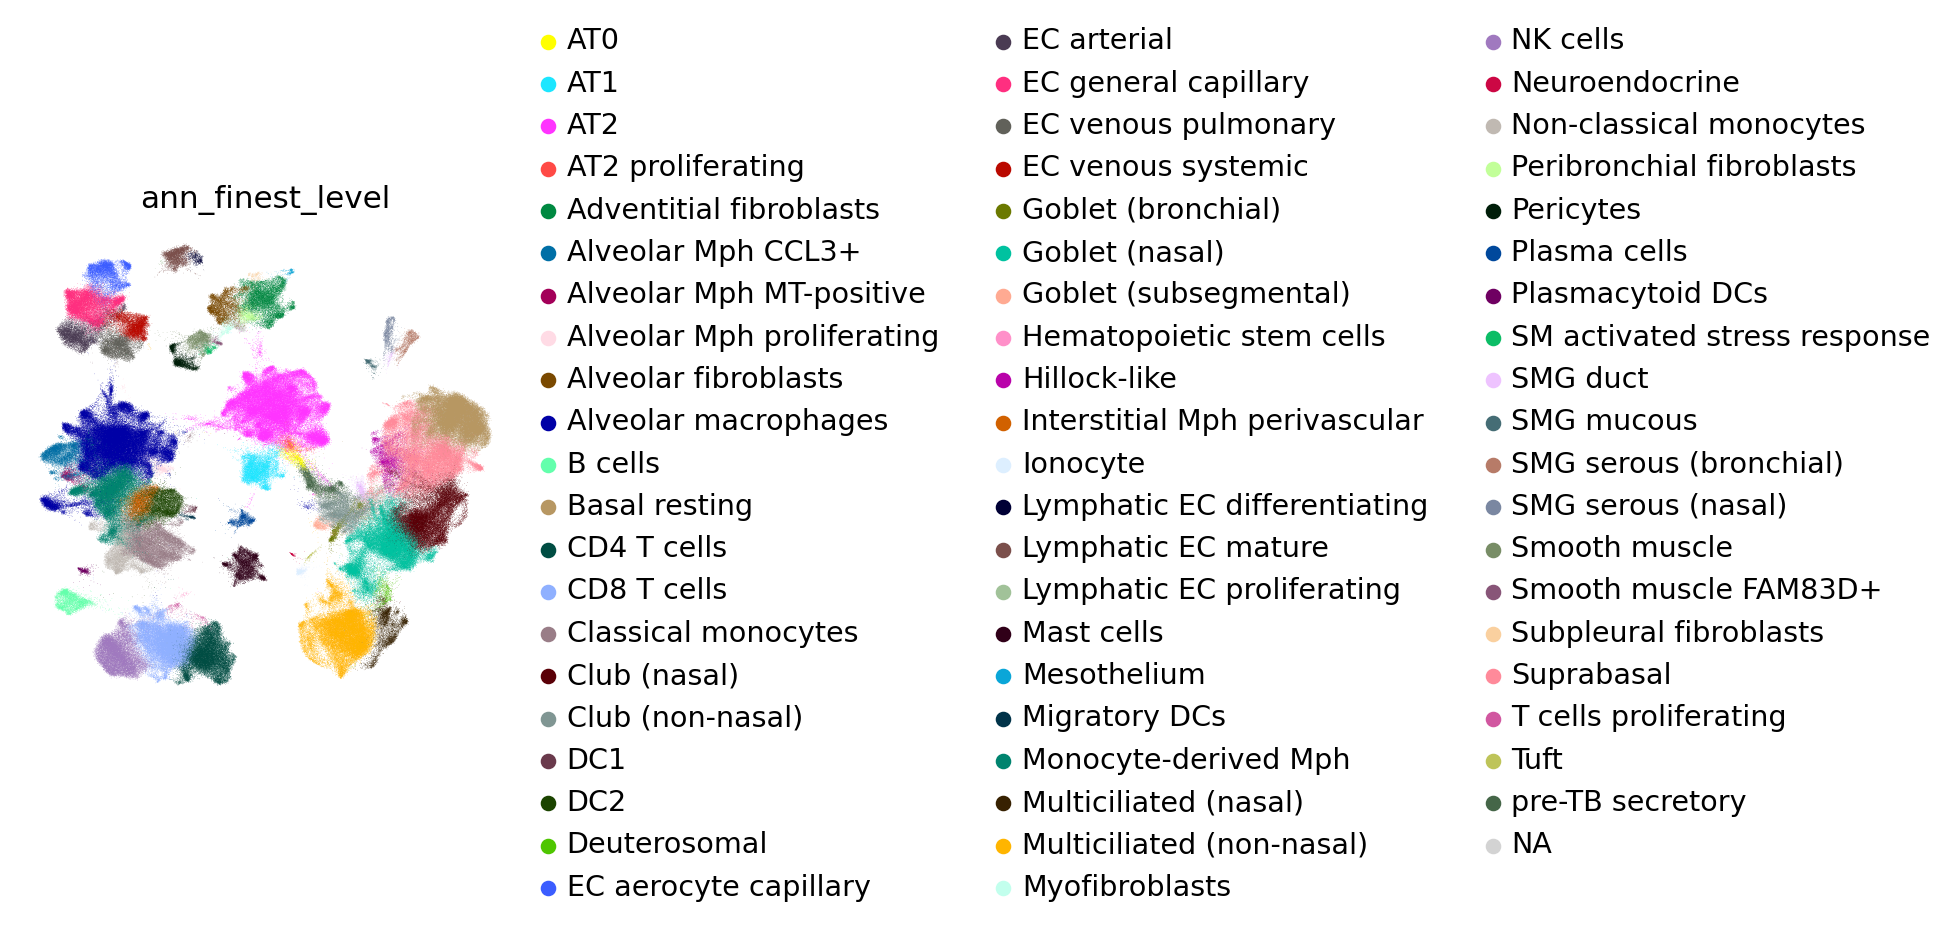

In [70]:
sc.pl.umap(combined_emb, color="ann_finest_level", frameon=False, wspace=0.6)

To visualize the original labels that were transferred per level, run the code below:

In [71]:
# # copy over labels from reference adata
# for cat in [f"labtransf_ann_level_{lev}" for lev in range(1,6)]:
#     combined_emb.obs.loc[adata_ref.obs.index, cat] = adata_ref.obs[cat]

In [72]:
# sc.pl.umap(
#     combined_emb,
#     color=[f"labtransf_ann_level_{lev}" for lev in range(1,6)],
#     frameon=False,
#     wspace=1.4,
#     ncols=2,
# )

## Visualization of the query alone, using reference-based embedding and including original gene expression values:

To get a better look at the query and the uncertainty levels, we can go back to the original query object (without reference, and with all genes still included), add the learned embedding and transfered labels, and calculate the UMAP:

In [73]:
adata_query_final = (
    adata_query_unprep.copy()
)  # copy the original query adata, including gene counts

In [74]:
adata_query_final.obsm["X_scarches_emb"] = adata_query_latent[
    adata_query_final.obs.index, :
].X  # copy over scArches/reference-based embedding

If your original query_adata has gene ids instead of gene symbols as var.index, switch that here for easier gene querying. Adapt column names where necessary.

In [75]:
adata_query_final.var["gene_ids"] = adata_query_final.var.index
adata_query_final.var.index = adata_query_final.var.gene_names
adata_query_final.var.index.name = None

normalize gene counts and log transform (we'll do a simple total counts normalization here for simplicity):

In [76]:
sc.pp.normalize_per_cell(adata_query_final, counts_per_cell_after=10000)
sc.pp.log1p(adata_query_final)

copy over label transfer columns:

In [77]:
for col in combined_emb.obs.columns:
    if col.startswith("ann_level") and "transfer" in col:
        adata_query_final.obs[col] = combined_emb.obs.loc[
            adata_query_final.obs.index, col
        ]

calculate neigbhor graph based on scArches embedding, and generate UMAP:

In [78]:
sc.pp.neighbors(adata_query_final, use_rep="X_scarches_emb")
sc.tl.umap(adata_query_final)

Visualize label transfer details for a level of choice:

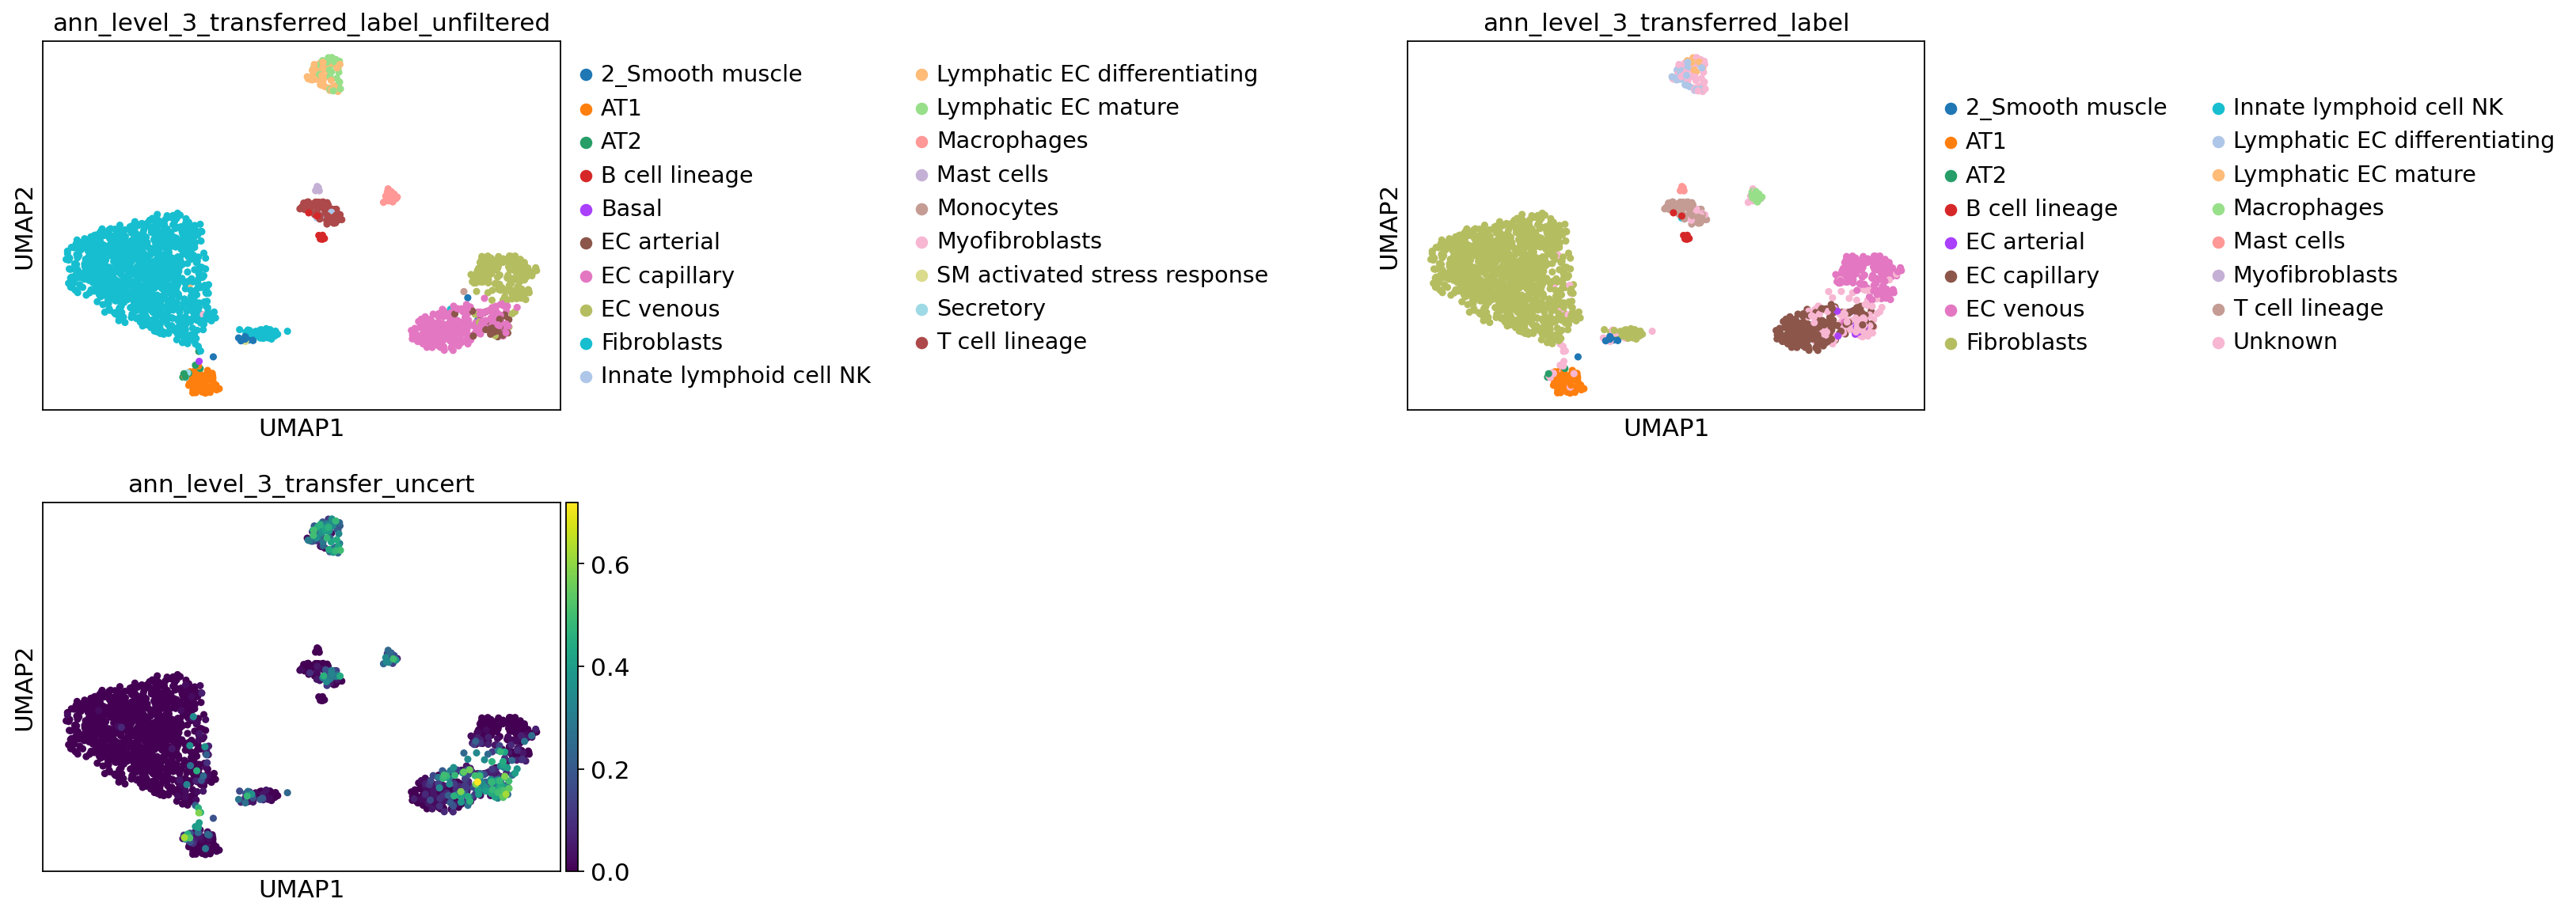

In [79]:
lev = 3
sc.pl.umap(
    adata_query_final,
    color=[
        f"ann_level_{lev}_transferred_label_unfiltered",
        f"ann_level_{lev}_transferred_label",
        f"ann_level_{lev}_transfer_uncert",
    ],
    wspace=1.4,
    ncols=2,
)

Now visualize gene expression of any genes of your interest:

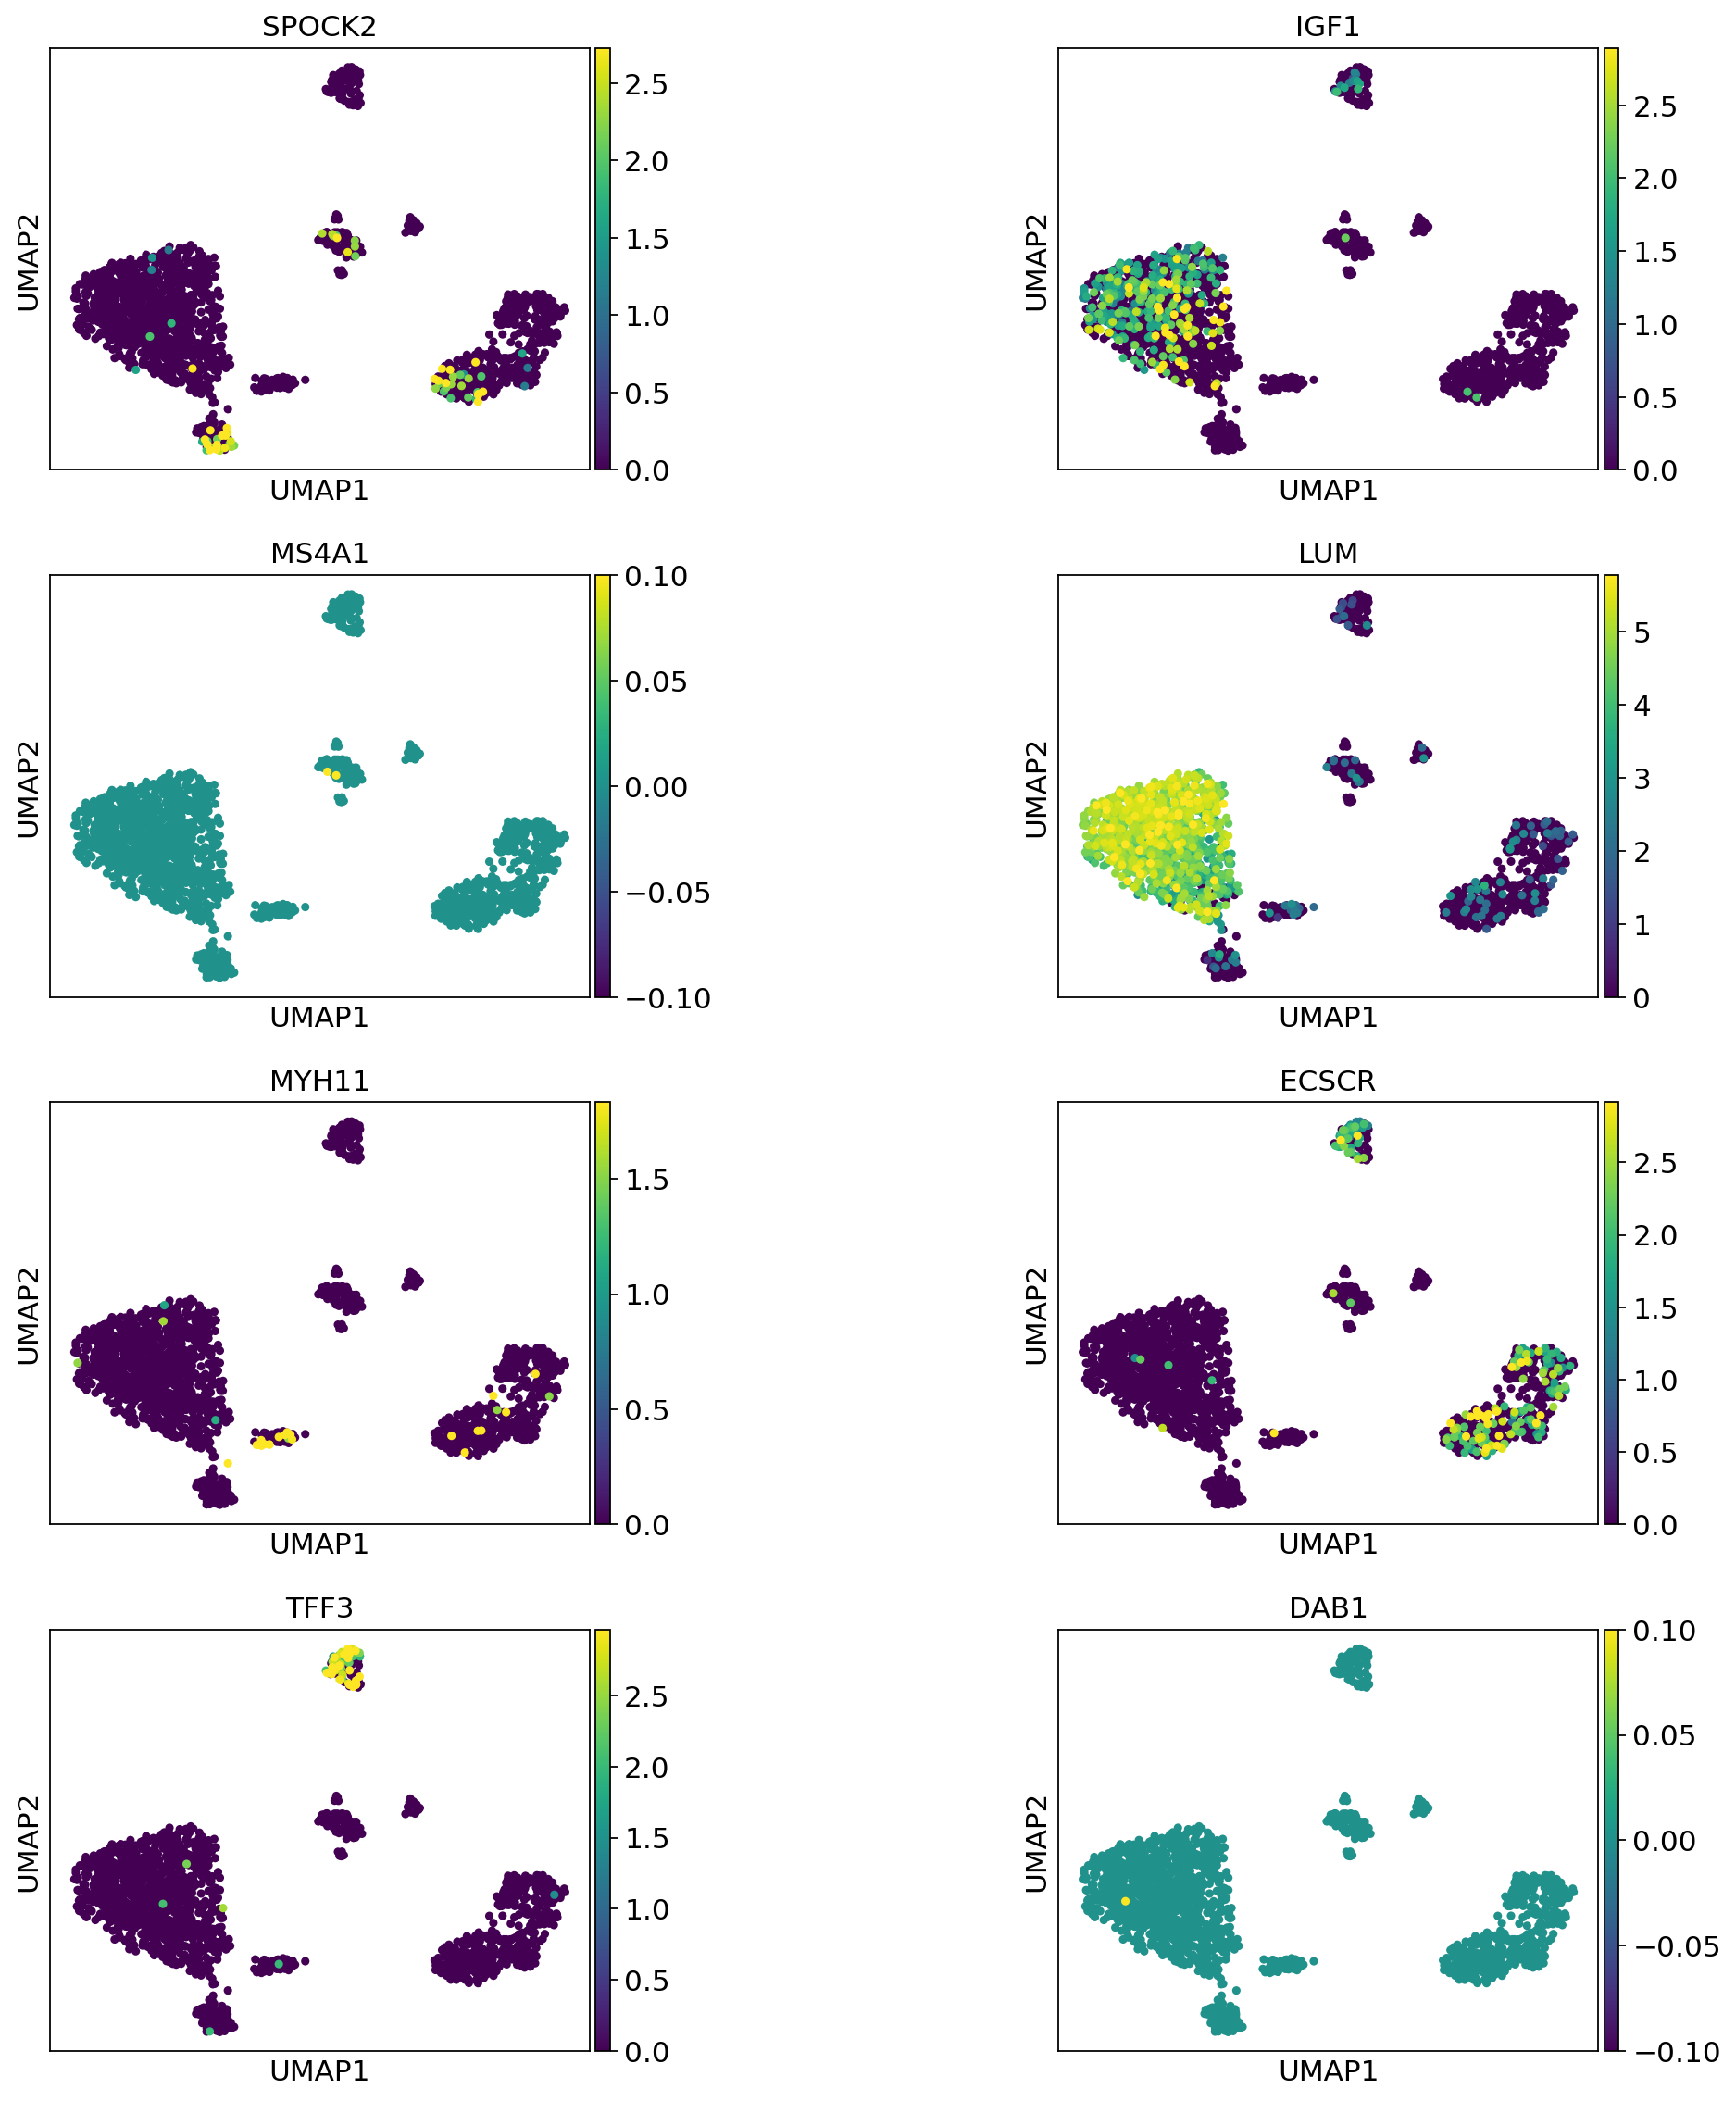

In [80]:
sc.pl.umap(
    adata_query_final,
    color=["SPOCK2", "IGF1", "MS4A1", "LUM", "MYH11", "ECSCR", "TFF3", "DAB1"],
    vmax="p99",
    wspace=0.7,
    ncols=2,
)

Store the final adata_query if wanted:

In [81]:
# adata_query_final.write_h5ad("./query_with_refbased_emb_and_anns.h5ad")